# Data description
**1. Gold prices and volume:**
- gold_open: Opening price of gold for the trading day
- gold_high: Highest price of gold during the trading day
- gold_low: Lowest price of gold during the trading day
- gold_close: Closing price of gold during the trading day. Used in trend analysis and modeling.
- gold_volume: Volume of gold traded, reflecting market activity and liquidity

**2. Other precious metals and energy commodities:**
- silver_close
- platinum_close
- palladium_close
- oil_close

**3. Financial market indices:**
- sp500 close: Closing value of the S&P 500 Index, representing the performance of 500 large-cap US companies
- nasdaq_close: Closing value of the NASDAQ Index, dominated by technology companies

**4. Currency exchange rates**
- usd_chf: Exchange rate between USD and CHF
- eur_usd: Exchange rate between EUR and USD

**5. Economic indicators:**
- CPI: Consumer Price Index. Indicator of inflation
- GDP: Gross Domestic Product. Indicating economic health and growth
- us_rates_%: Federal funds rate or other key interest rates in the United States, expressed as a percentage

# Load and analyze data

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
data = pd.read_csv('../financial_regression.csv', sep = ',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                3904 non-null   object 
 1   sp500 open          3719 non-null   float64
 2   sp500 high          3719 non-null   float64
 3   sp500 low           3719 non-null   float64
 4   sp500 close         3719 non-null   float64
 5   sp500 volume        3719 non-null   float64
 6   sp500 high-low      3719 non-null   float64
 7   nasdaq open         3719 non-null   float64
 8   nasdaq high         3719 non-null   float64
 9   nasdaq low          3719 non-null   float64
 10  nasdaq close        3719 non-null   float64
 11  nasdaq volume       3719 non-null   float64
 12  nasdaq high-low     3719 non-null   float64
 13  us_rates_%          176 non-null    float64
 14  CPI                 176 non-null    float64
 15  usd_chf             3694 non-null   float64
 16  eur_us

We observe missing data for indicators such as CPI, GDP and us_rates_%. This is because we have monthly data for CPI and us_rates_%, while for GDP we have trimestral data available. In order to fill all the columns we fill the missing data with the next available data of every first day of the month, so then we have all the month filled with the corresponding data.

In [22]:
columns_to_fill = ['us_rates_%', 'CPI', 'GDP']
data[columns_to_fill] = data[columns_to_fill].fillna(method='bfill') # fill with next available data of the column
# Verify that missing data has been filled
display(data[columns_to_fill].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   us_rates_%  3866 non-null   float64
 1   CPI         3866 non-null   float64
 2   GDP         3755 non-null   float64
dtypes: float64(3)
memory usage: 91.6 KB


None

After backfilling, missing data for these indicators is significantly reduced, as shown in the heatmap below.

In [23]:
# Convert date to Datetime
data['date'] = pd.to_datetime(data['date'])
# Set the variable as an index
data.set_index('date', inplace=True)

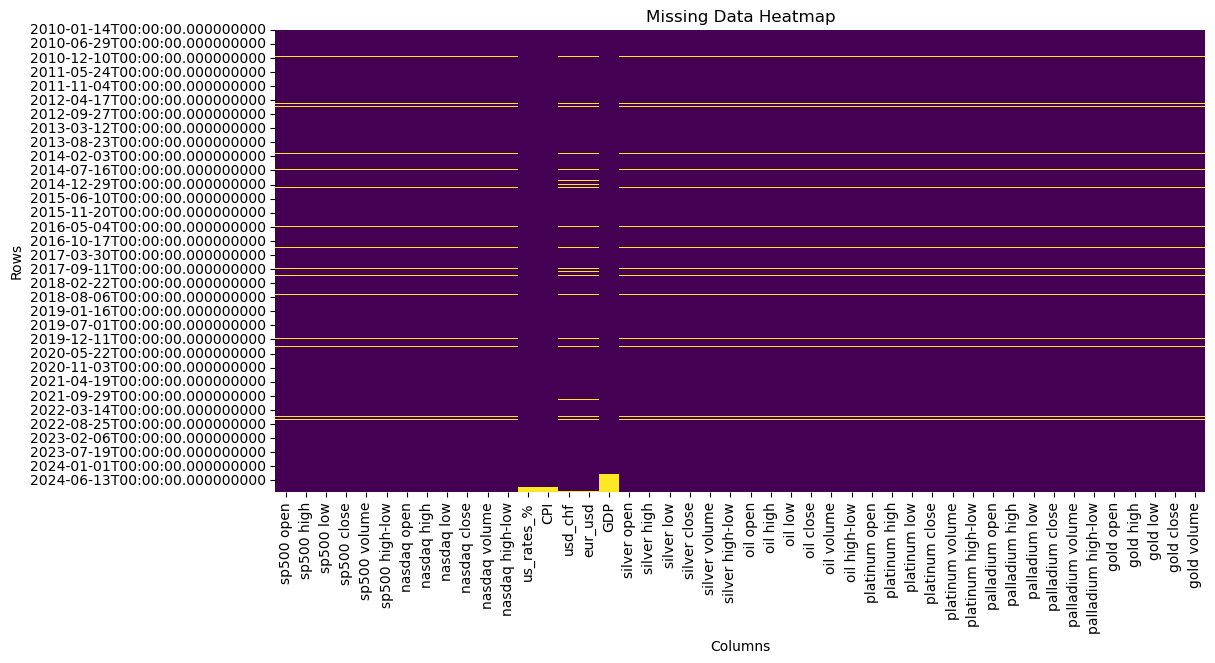

In [24]:
# Visualize missing data
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

The heatmap above highlights the missing data. We observe that there are some empty rows that we could consider to eliminate in order to avoid their impact in their usability in analysis or modeling. ALso it is worth to mention that we don't have data on the CPI, us_rates_% and GDP indicators for the last months of 2024. It could be either interesting to search for the data and fil the missing values or either leave it like that, given the sufficient historical data available for analysis.

In [25]:
# Eliminate rows with NaN values
data_cleaned = data.dropna()
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {data_cleaned.shape}")
data=data_cleaned

Original data shape: (3904, 46)
Cleaned data shape: (3538, 46)


# Summary statistics

In [26]:
data.describe()

,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq open,nasdaq high,nasdaq low,nasdaq close,...,palladium high,palladium low,palladium close,palladium volume,palladium high-low,gold open,gold high,gold low,gold close,gold volume
count,3538.000000,3538.000000,3538.000000,3538.000000,3.538000e+03,3538.000000,3538.000000,3538.000000,3538.000000,3538.000000,...,3538.000000,3538.000000,3538.000000,3.538000e+03,3538.000000,3538.000000,3538.000000,3538.000000,3538.000000,3.538000e+03
mean,257.651915,259.060438,256.128189,257.702925,1.150930e+08,2.932249,169.915946,171.143339,168.589452,169.960701,...,110.856955,108.602333,109.738503,7.055238e+04,2.254622,142.249114,142.879776,141.570714,142.244161,9.784852e+06
std,110.356251,110.997967,109.681625,110.387768,6.938739e+07,2.615793,110.575056,111.465035,109.614429,110.604399,...,59.461990,57.852553,58.680904,9.893075e+04,2.594396,25.283979,25.413015,25.116225,25.282035,6.266379e+06
min,103.110000,103.420000,101.130000,102.200000,1.708170e+05,0.300000,42.670000,42.821500,41.550000,42.470000,...,40.550000,38.490000,40.090000,3.157000e+03,0.230000,100.920000,100.990000,100.232600,100.500000,1.436508e+06
25%,167.050000,167.612500,165.830000,166.697500,6.914605e+07,1.260500,75.500000,75.890000,75.212500,75.440000,...,68.827350,67.742500,68.312500,2.038150e+04,0.850000,120.277500,120.770000,119.780875,120.287500,5.913007e+06
50%,232.835000,234.205000,231.830000,233.105000,9.507754e+07,2.000000,129.225000,129.725000,128.980000,129.550000,...,81.780000,80.615050,81.170000,3.683200e+04,1.366150,134.300000,135.065000,133.615000,134.390000,8.201228e+06
75%,336.685000,338.287500,334.822500,336.922500,1.400183e+08,3.590000,268.627500,271.470000,265.297500,268.815000,...,146.859025,144.163450,145.586600,8.145750e+04,2.700225,166.225000,166.918750,165.500000,166.315000,1.170106e+07
max,523.830000,524.610000,522.780000,523.170000,7.095045e+08,22.960000,448.880000,449.340000,445.670000,446.380000,...,298.210000,277.000100,295.000000,1.199042e+06,45.392300,208.680000,208.730000,206.290000,207.820000,9.369811e+07


# Historical gold prices and correlation analysis

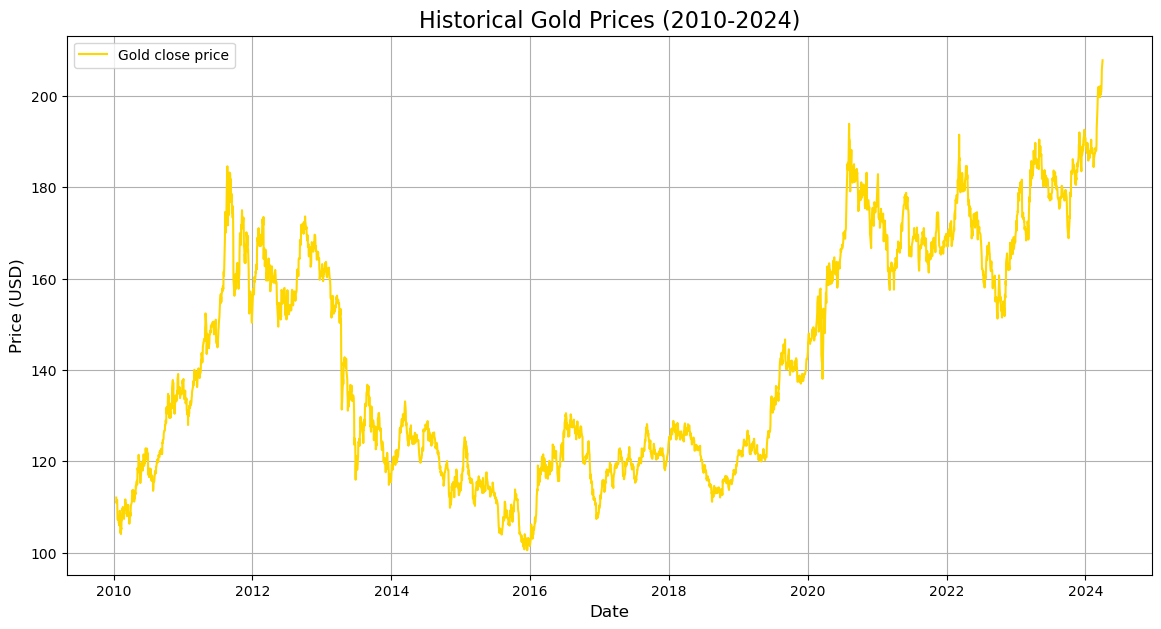

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['gold close'], label='Gold close price', color='gold')
plt.title('Historical Gold Prices (2010-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Analysis of global events impacting gold price trends
**2008–2011: Aftermath of the Global Financial Crisis:**
The 2008 financial crisis caused widespread economic instability and a loss of confidence in financial markets, driving gold prices to record highs as investors sought a reliable store of value. Gold prices remained elevated through 2011, fueled by concerns over sovereign debt crises in Europe and quantitative easing policies by central banks, which raised inflation fears.

**2013–2015: Taper Tantrum and Economic Recovery:**
Gold prices declined significantly during this period as the U.S. Federal Reserve announced plans to taper its quantitative easing program. This led to rising confidence in equity markets and a stronger U.S. dollar, reducing gold's appeal. Economic recovery in developed nations further contributed to declining demand for gold.

**2016: Brexit and Political Uncertainty:**
The U.K.'s decision to leave the European Union (Brexit) triggered a brief surge in gold prices due to heightened uncertainty in global markets. This event highlighted gold's role as a hedge during periods of geopolitical instability.

**2020: COVID-19 Pandemic:**
The onset of the COVID-19 pandemic led to a sharp spike in gold prices, as economic shutdowns and a global recession caused market turmoil. Central banks responded with aggressive monetary easing, further boosting gold's appeal. By mid-2020, gold reached an all-time high, driven by fears of prolonged uncertainty and inflationary pressures.

**2022: Rising Interest Rates and Strong U.S. Dollar:**
In response to surging inflation, the U.S. Federal Reserve and other central banks implemented aggressive interest rate hikes. Higher interest rates reduced gold's attractiveness as a non-yielding asset. Additionally, a strong U.S. dollar made gold more expensive for international buyers, leading to a decline in demand and prices.

**2022–2024: Ongoing Geopolitical Tensions and Economic Adjustments:**
Events like the Russia-Ukraine conflict, fluctuating energy prices, and fears of a global economic slowdown have introduced volatility into gold prices. While geopolitical tensions supported gold as a safe-haven asset, these were counterbalanced by central banks' efforts to stabilize inflation through monetary tightening.

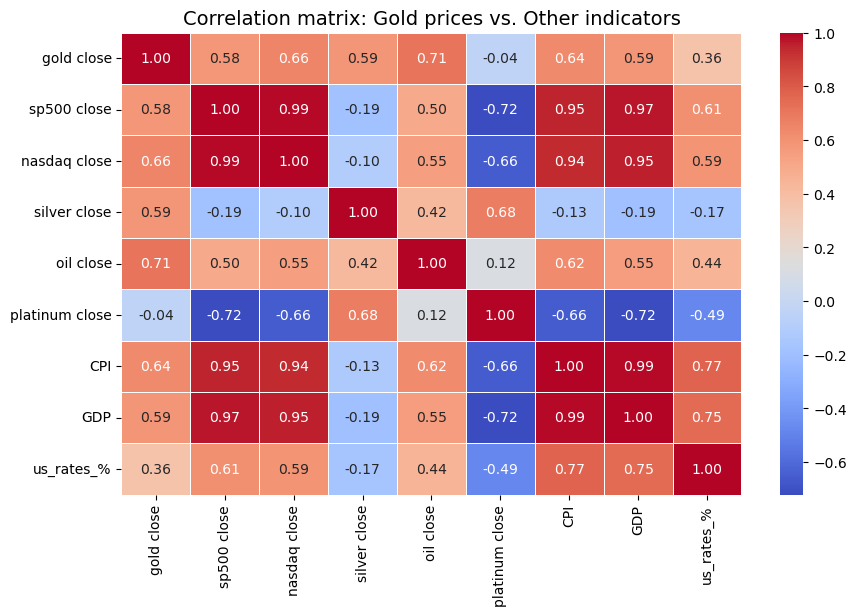

In [28]:
selected_columns = ['gold close', 'sp500 close', 'nasdaq close', 'silver close', 'oil close', 'platinum close', 'CPI', 'GDP', 'us_rates_%']
correlation_data = data[selected_columns]
# Correlation matrix
correlation_matrix = correlation_data.corr()
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix: Gold prices vs. Other indicators', fontsize=14)
plt.show()

This heatmap shows the strength and direction of correlations between gold prices and other financial indicators. For instance, gold correlate strongly with oil prices and indices like nasdaq or CPI, but less with prices like platinum.

# Comparison

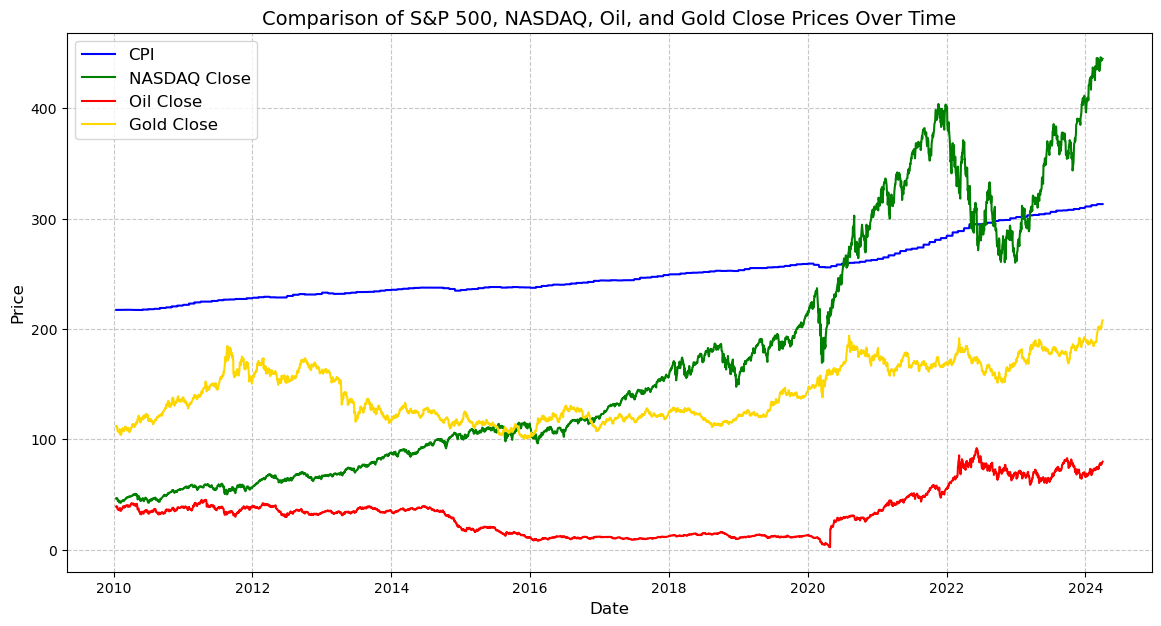

In [29]:
# Plotting multiple lines for most correlated variables
plt.figure(figsize=(14, 7))

# Plot CPI close
plt.plot(data.index, data['CPI'], label='CPI', color='blue')

# Plot NASDAQ close
plt.plot(data.index, data['nasdaq close'], label='NASDAQ Close', color='green')

# Plot Oil close
plt.plot(data.index, data['oil close'], label='Oil Close', color='red')

# Plot Gold close
plt.plot(data.index, data['gold close'], label='Gold Close', color='gold')

plt.title('Comparison of S&P 500, NASDAQ, Oil, and Gold Close Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# Further analysis and preprocessing for the visual tool

In [30]:
# Create 'month' and 'year' columns
data['month'] = data.index.month # 1,2,...12
data['year'] = data.index.year

Monthly average gold prices

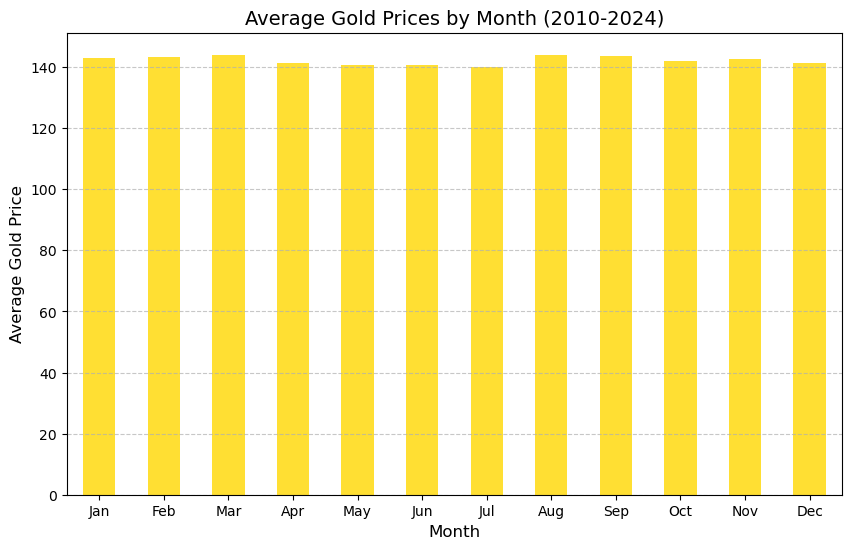

In [31]:
# Group by month to calculate the average gold close price
monthly_avg_gold = data.groupby('month')['gold close'].mean()

plt.figure(figsize=(10, 6))
monthly_avg_gold.plot(kind='bar', color='gold', alpha=0.8)
plt.title('Average Gold Prices by Month (2010-2024)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Gold Price', fontsize=12)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Yearly trends in gold prices

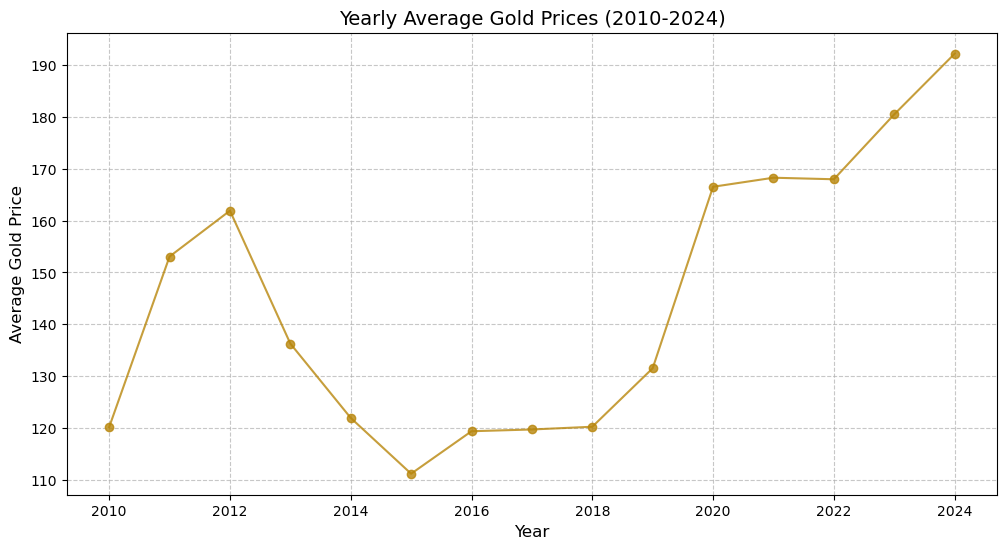

In [32]:
# Group by year to calculate the average gold close price
yearly_avg_gold = data.groupby('year')['gold close'].mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_gold.index, yearly_avg_gold.values, marker='o', color='darkgoldenrod', alpha=0.8)
plt.title('Yearly Average Gold Prices (2010-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Gold Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Download the final dataset

In [33]:
data.to_csv('final_dataset.csv')
data.to_csv('../Streamlit_app/final_dataset.csv')
